# Forces

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
sys.path.insert(0, '../../../icenumerics/')
sys.path.insert(0, './../auxnumerics/')
sys.path.insert(0, '../')
import icenumerics as ice


from parameters import params
import auxiliary as aux
import montecarlo_colloids as mc
import vertices as vrt

ureg = ice.ureg

%reload_ext autoreload
%autoreload 2

idx = pd.IndexSlice

In [2]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'xtick.labelsize':11,
    'ytick.labelsize':11,
    'axes.labelsize':11,
})

In [3]:
DRIVE = '/home/frieren/BIG/'
DRIVE = '/mnt/BIG/'
PROJECT = 'reentrancy/test11'
SIZE = 10
DATA_PATH = os.path.join(DRIVE,PROJECT,str(SIZE))

In [4]:
data = pd.read_csv(os.path.join(DATA_PATH,'kappa_all.csv'))
data.t = np.round(data.t,3)
data.kappa = np.abs(data.kappa)
# get the mapping omega : max_time
maxt = {tt:dfw.t.max() for tt,dfw in data.groupby('total_time') }
# get the last frames
data_lastframes = pd.concat([data.query(f'total_time=={tt} & t=={tmax}') for tt,tmax in maxt.items()],axis=0)
# average across realizations
averaged = data_lastframes.groupby(['total_time','field','t'])['kappa'].mean().to_frame().reset_index()

In [5]:
averaged['omega'] = np.round(np.pi/2/averaged['total_time'],4)

omegas = averaged.omega.unique()
fields = averaged.field.unique()

W, B = np.meshgrid(omegas,fields)

In [6]:
rows,cols = W.shape

K = np.zeros(W.shape)
for i in range(rows):
    for j in range(cols):
        K[i,j] =  averaged.query(f'omega=={W[i,j]} & field=={B[i,j]}')['kappa'].to_numpy()[0]

K = K /4/params['size']**2

In [ ]:
low = 0.3
high = 0.99

K[K<=low] = 0
K[(K>low)*(K<=high)] = 0.5
K[K>high] = 1

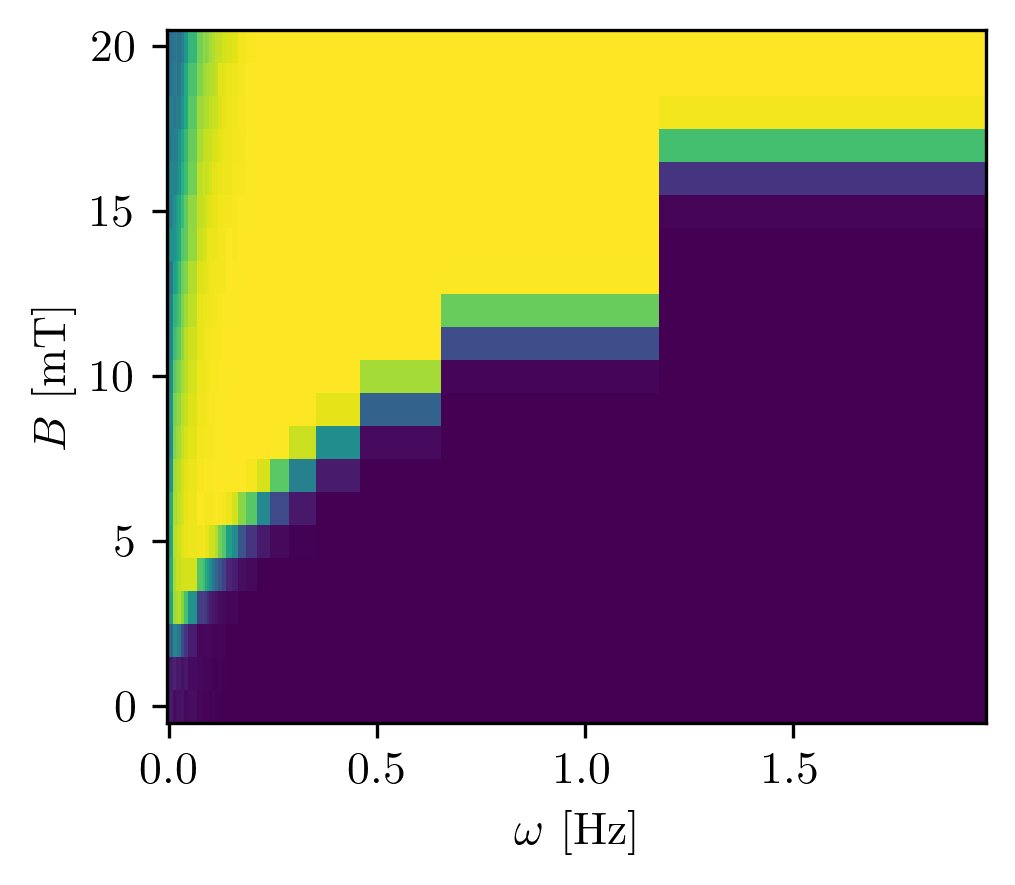

In [12]:
COL=246/72
OFFSET=0.11
fig, ax = plt.subplots(figsize=(3.41+0.11, 3), dpi=300)

norm = plt.Normalize(0,1)
cmap = plt.get_cmap('viridis')

c = ax.pcolormesh(W, B, K, norm=norm, cmap=cmap, rasterized=True)
ax.set_xlabel('$\\omega$ [Hz]')
ax.set_ylabel('$B$ [mT]')


# ==========================================================================================================
# COLORBAR
# ==========================================================================================================

#fig.subplots_adjust(bottom=0.25)
#fig.subplots_adjust(left=0.2)

#cbar_ax = fig.add_axes([0.2, 0.05, 0.7, 0.01])  # [left, bottom, width, height]
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#
#cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
#cbar.ax.tick_params(labelsize=10)
#
#custom_ticks = [0,1]
#cbar.set_ticks(custom_ticks)
#cbar.set_ticklabels(custom_ticks)
#
#fig.text(0.15, 0.05, '$\\kappa$', fontsize=10, ha='center', va='center')


fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig6.pdf',dpi=300,bbox_inches='tight')
fig.savefig('/home/frieren/Dropbox/mnt/martensitepaper/fig6.png',dpi=300,bbox_inches='tight')

plt.show()